# Customer Churn Model

In this notebook we build a customer churn model using [pycaret](https://pycaret.org/). Most of the codes are taken from the following articles written by [Moez Ali](https://ca.linkedin.com/in/profile-moez), the creator of pycaret: 

* [Predict Customer Churn (the right way) Using Pycaret](https://towardsdatascience.com/predict-customer-churn-the-right-way-using-pycaret-8ba6541608ac)
* [Introduction to Binary Classification with Pycaret](https://towardsdatascience.com/introduction-to-binary-classification-with-pycaret-a37b3e89ad8d)
* [Easy MLOps with Pycaret and MLflow](https://towardsdatascience.com/easy-mlops-with-pycaret-mlflow-7fbcbf1e38c6)
* [Deploy Machine Learning App Built Using Streamlit and Pycaret on Google Kubernetes Engine](https://towardsdatascience.com/deploy-machine-learning-app-built-using-streamlit-and-pycaret-on-google-kubernetes-engine-fd7e393d99cb)

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from pycaret.classification import *

import matplotlib.pyplot as plt
%matplotlib inline  

import mlflow
#set tracking uri for mlflow
mlflow.set_tracking_uri("sqlite:///mlruns.db")

#supress default INFO logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#random seed
seed = 42

#whether to use gpu
use_gpu = True

## Read the data

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/srees1988/predict-churn-py/main/customer_churn_data.csv")

In [3]:
data.shape

(7043, 21)

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# run pandas profiling report
profile = ProfileReport(data)
profile.to_file("data_profiling.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

See the pandas report at http://localhost:8888/view/data_profiling.html

### Fix the TotalCharges variable

In [6]:
#fix the type of TotalCharges, replace ' ' by missing values
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan)
data['TotalCharges'] = data['TotalCharges'].astype('float64')

In [7]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### Split the data into train and test

In [8]:
# split the data into train and test
X = data.drop('Churn', axis = 1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)
data_train = pd.concat([X_train, y_train], axis = 1)
data_test = pd.concat([X_test, y_test], axis = 1)
print(f"Shape of train data is {data_train.shape}")
print(f"Shape of test data is {data_test.shape}")

Shape of train data is (5634, 21)
Shape of test data is (1409, 21)


## Experiment 1

In this experiment we use the default option in pycaret

In [9]:
s1 = setup(data_train, target = 'Churn', ignore_features=['customerID'], session_id = seed, 
          log_experiment= True, experiment_name = 'Churn_1', use_gpu=use_gpu)

,Description,Value
0,session_id,42
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(5634, 21)"
5,Missing Values,True
6,Numeric Features,3
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


2021/12/28 15:30:48 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2021/12/28 15:30:48 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

INFO  [logs] setup() succesfully completed......................................


### Compare and the select best model based on AUC (cv_fold = 10)

In [10]:
#compare all models
best_model_1 = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8019,0.8422,0.5224,0.6634,0.5834,0.4561,0.4624,0.4290
lr,Logistic Regression,0.8017,0.8403,0.5425,0.6547,0.5923,0.4630,0.4672,0.1900
ada,Ada Boost Classifier,0.8009,0.8384,0.5358,0.6542,0.5880,0.4587,0.4633,0.1400
catboost,CatBoost Classifier,0.7898,0.8362,0.4976,0.6348,0.5573,0.4222,0.4279,1.2950
lda,Linear Discriminant Analysis,0.7941,0.8336,0.5500,0.6296,0.5864,0.4503,0.4526,0.0430
lightgbm,Light Gradient Boosting Machine,0.7862,0.8291,0.4967,0.6242,0.5525,0.4146,0.4197,0.1430
nb,Naive Bayes,0.7413,0.8259,0.7807,0.5095,0.6162,0.4340,0.4570,0.0070
rf,Random Forest Classifier,0.7852,0.8211,0.4728,0.6281,0.5390,0.4027,0.4099,0.6520
xgboost,Extreme Gradient Boosting,0.7761,0.8166,0.4948,0.5990,0.5406,0.3945,0.3985,0.2550
et,Extra Trees Classifier,0.7667,0.7892,0.4585,0.5772,0.5103,0.3600,0.3645,0.6860


INFO  [logs] create_model_container: 16
INFO  [logs] master_model_container: 16
INFO  [logs] display_container: 2
INFO  [logs] GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO  [logs] compare_models() succesfully completed......................................


In [11]:
#print best model
print(best_model_1)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### Tune the best model via Bayesian grid search

In [12]:
#tune model via baeysian search
tuned_best_model_1 = tune_model(best_model_1, optimize = 'AUC', search_library='tune-sklearn',
                               search_algorithm = 'hyperopt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8101,0.8546,0.5333,0.6829,0.5989,0.4770,0.4833
1,0.7924,0.8411,0.5143,0.6353,0.5684,0.4337,0.4379
2,0.7975,0.8502,0.6000,0.6238,0.6117,0.4747,0.4749
3,0.8376,0.8340,0.5962,0.7381,0.6596,0.5545,0.5599
4,0.7970,0.8370,0.4952,0.6582,0.5652,0.4362,0.4437
5,0.7944,0.8259,0.5143,0.6429,0.5714,0.4384,0.4431
6,0.7893,0.8427,0.4667,0.6447,0.5414,0.4092,0.4182
7,0.8071,0.8516,0.5333,0.6747,0.5957,0.4713,0.4770
8,0.8325,0.8548,0.5143,0.7826,0.6207,0.5190,0.5379
9,0.8274,0.8724,0.5810,0.7176,0.6421,0.5300,0.5352


INFO  [logs] create_model_container: 17
INFO  [logs] master_model_container: 17
INFO  [logs] display_container: 3
INFO  [logs] GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1689697248156227, loss='deviance',
                           max_depth=1, max_features=0.4661484159689558,
                           max_leaf_nodes=None,
                           min_impurity_decrease=2.8260904858116558e-09,
                           min_impurity_split=None, min_samples_leaf=2,
                           min_samples_split=10, min_weight_fraction_leaf=0.0,
                           n_estimators=224, n_iter_no_change=None,
                           presort='deprecated', random_state=42,
                           subsample=0.41633220949318217, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO  [logs] tune_model() succesfully completed............

### Output plots

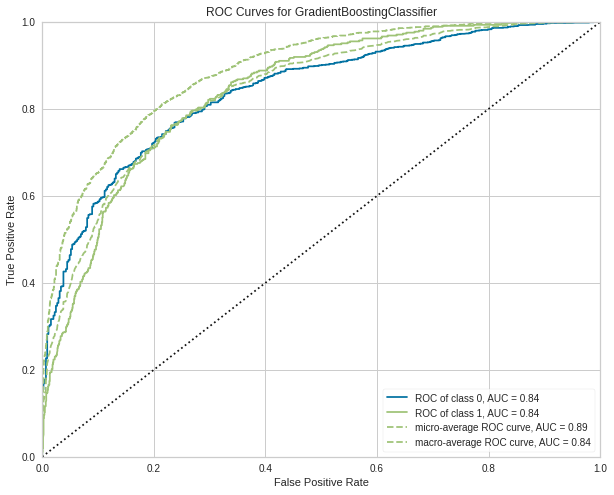

INFO  [logs] Visual Rendered Successfully
INFO  [logs] plot_model() succesfully completed......................................


In [13]:
#AUC plot
plt.figure(figsize = (10,8))
plot_model(tuned_best_model_1, plot = 'auc')

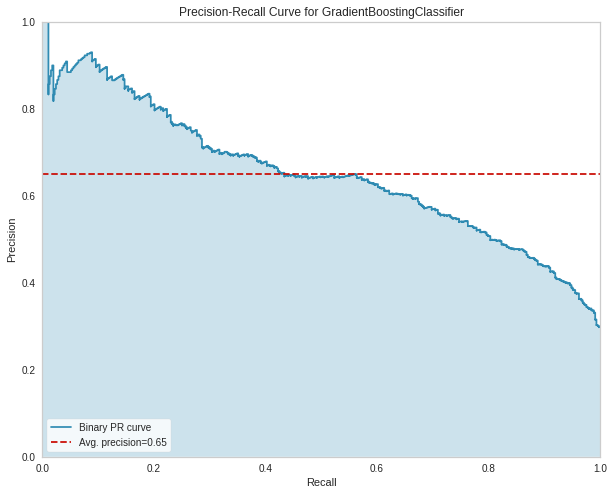

INFO  [logs] Visual Rendered Successfully
INFO  [logs] plot_model() succesfully completed......................................


In [14]:
#precision-recall curve
plt.figure(figsize=(10,8))
plot_model(tuned_best_model_1, plot='pr')

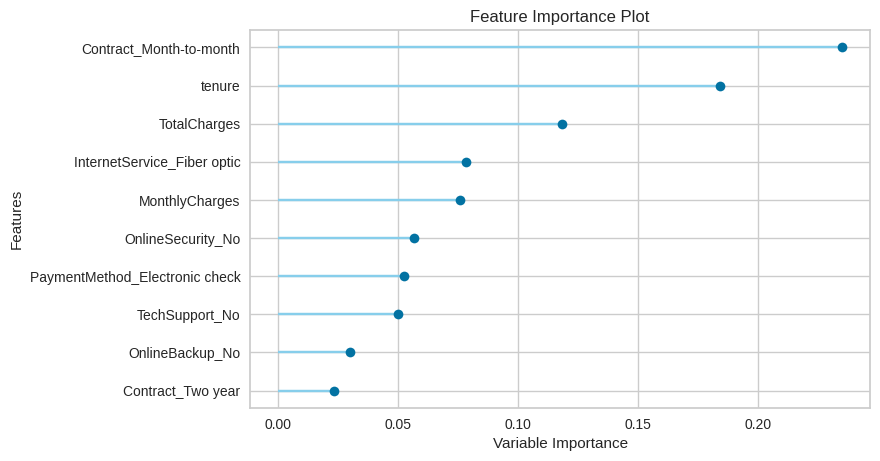

INFO  [logs] Visual Rendered Successfully
INFO  [logs] plot_model() succesfully completed......................................


In [15]:
#feature importance plot
plot_model(tuned_best_model_1, plot='feature')

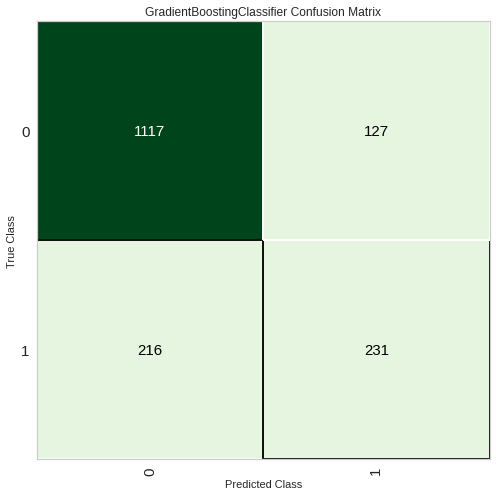

INFO  [logs] Visual Rendered Successfully
INFO  [logs] plot_model() succesfully completed......................................


In [16]:
#confusion matrix
plt.figure(figsize=(7,7))
plot_model(tuned_best_model_1, plot='confusion_matrix')

### Finalize the best model by training it on the whole data

In [17]:
#finalize the model
final_best_1 = finalize_model(tuned_best_model_1)

#save model to disk
save_model(final_best_1, 'churn_best_1')

INFO  [logs] Initializing finalize_model()
INFO  [logs] finalize_model(estimator=GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1689697248156227, loss='deviance',
                           max_depth=1, max_features=0.4661484159689558,
                           max_leaf_nodes=None,
                           min_impurity_decrease=2.8260904858116558e-09,
                           min_impurity_split=None, min_samples_leaf=2,
                           min_samples_split=10, min_weight_fraction_leaf=0.0,
                           n_estimators=224, n_iter_no_change=None,
                           presort='deprecated', random_state=42,
                           subsample=0.41633220949318217, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), fit_kwargs=None, groups=None, model_only=True, display=None)
INFO  [logs] Finalizing GradientBoostingCla

INFO  [logs] Adding model into prep_pipe
INFO  [logs] churn_best_1.pkl saved in current working directory
INFO  [logs] Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True,
                                      features_todrop=['customerID'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='Churn',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                nu...
                                            max_features=0.4661484159689558,
                                            max_leaf_

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['customerID'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Churn',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nu...
                                             max_features=0.4661484159689558,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=2.8260904858116558e-09,


### Launch MLflow UI

In order to launch the mlflow ui, one needs to perform the following commands on the terminal

* cd to the folder that contains the jupyter notebook
* activate the env: **conda activate <env_name>**
* launch the mlflow ui: **mlflow ui --backend-store-uri sqlite:///mlruns.db**

Then go to http://localhost:5000 to view the results

## Experiment 2

In this experiment, we add normalization option and allow polynomial features

In [18]:
s2 = setup(data_train, target = 'Churn', ignore_features=['customerID'], session_id = seed, 
          log_experiment= True, experiment_name = 'Churn_2', 
          use_gpu=use_gpu, normalize = True, polynomial_features = True)

,Description,Value
0,session_id,42
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(5634, 21)"
5,Missing Values,True
6,Numeric Features,3
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


INFO  [logs] Logging experiment in MLFlow
INFO  [logs] SubProcess save_model() called ==================================
INFO  [logs] Initializing save_model()
INFO  [logs] save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True,
                                      features_todrop=['customerID'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='Churn',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                nu...
                                                  target='C

### Compare and the select best model based on AUC (cv_fold = 10)

In [19]:
#compare all models
best_model_2 = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8029,0.8438,0.5205,0.6671,0.5839,0.4575,0.4641,0.1620
gbc,Gradient Boosting Classifier,0.8012,0.8422,0.5205,0.6616,0.5815,0.4538,0.4600,0.5180
lda,Linear Discriminant Analysis,0.8024,0.8396,0.5425,0.6569,0.5931,0.4644,0.4688,0.0520
ada,Ada Boost Classifier,0.8009,0.8385,0.5358,0.6542,0.5880,0.4587,0.4633,0.1600
catboost,CatBoost Classifier,0.7897,0.8363,0.5033,0.6322,0.5599,0.4243,0.4293,1.3140
nb,Naive Bayes,0.7441,0.8267,0.7893,0.5128,0.6214,0.4411,0.4649,0.0070
lightgbm,Light Gradient Boosting Machine,0.7885,0.8262,0.5120,0.6259,0.5627,0.4251,0.4292,0.1340
rf,Random Forest Classifier,0.7915,0.8255,0.4862,0.6434,0.5534,0.4210,0.4282,0.6340
xgboost,Extreme Gradient Boosting,0.7761,0.8166,0.4948,0.5990,0.5406,0.3945,0.3985,0.2240
et,Extra Trees Classifier,0.7702,0.7983,0.4642,0.5868,0.5173,0.3695,0.3744,0.6790


INFO  [logs] create_model_container: 16
INFO  [logs] master_model_container: 16
INFO  [logs] display_container: 2
INFO  [logs] LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO  [logs] compare_models() succesfully completed......................................


In [20]:
#print best model
print(best_model_2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


### Tune the best model via Bayesian grid search

In [21]:
#tune model via baeysian search
tuned_best_model_2 = tune_model(best_model_2, optimize = 'AUC', search_library='tune-sklearn',
                               search_algorithm = 'hyperopt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8000,0.8507,0.5333,0.6512,0.5864,0.4562,0.4602
1,0.7899,0.8343,0.4952,0.6341,0.5561,0.4212,0.4267
2,0.7949,0.8556,0.5619,0.6277,0.5930,0.4565,0.4577
3,0.8249,0.8227,0.5577,0.7160,0.6270,0.5149,0.5218
4,0.7970,0.8365,0.4952,0.6582,0.5652,0.4362,0.4437
5,0.7893,0.8246,0.5048,0.6310,0.5608,0.4245,0.4291
6,0.7944,0.8365,0.4857,0.6538,0.5574,0.4273,0.4353
7,0.8071,0.8616,0.4857,0.6986,0.5730,0.4536,0.4661
8,0.8223,0.8506,0.5048,0.7465,0.6023,0.4933,0.5090
9,0.8096,0.8697,0.5619,0.6705,0.6114,0.4866,0.4900


INFO  [logs] create_model_container: 17
INFO  [logs] master_model_container: 17
INFO  [logs] display_container: 3
INFO  [logs] LogisticRegression(C=9.428772040268562, class_weight={}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO  [logs] tune_model() succesfully completed......................................


### Output plots

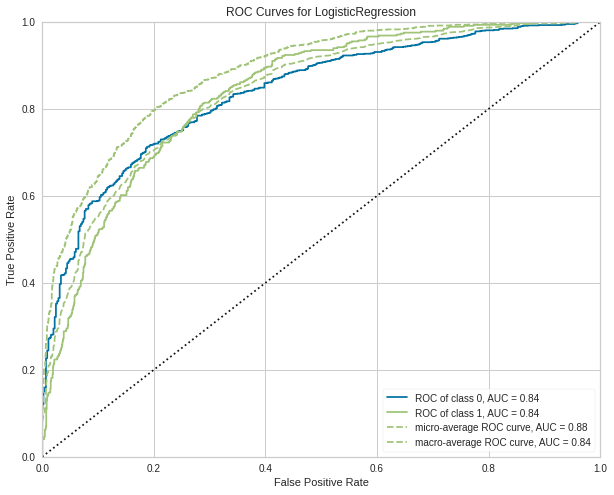

INFO  [logs] Visual Rendered Successfully
INFO  [logs] plot_model() succesfully completed......................................


In [22]:
#AUC plot
plt.figure(figsize = (10,8))
plot_model(tuned_best_model_2, plot = 'auc')

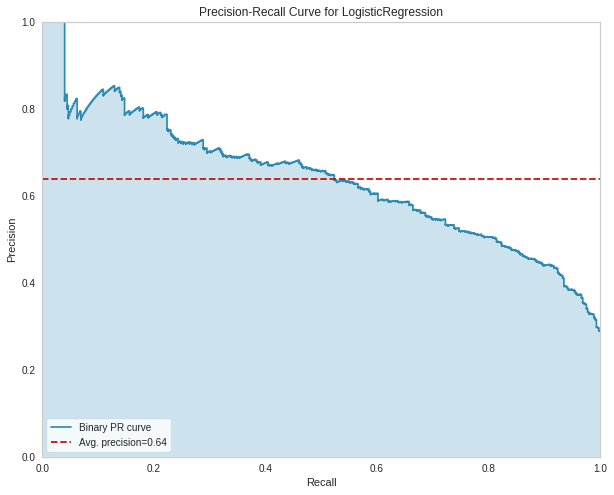

INFO  [logs] Visual Rendered Successfully
INFO  [logs] plot_model() succesfully completed......................................


In [23]:
#precision-recall curve
plt.figure(figsize=(10,8))
plot_model(tuned_best_model_2, plot='pr')

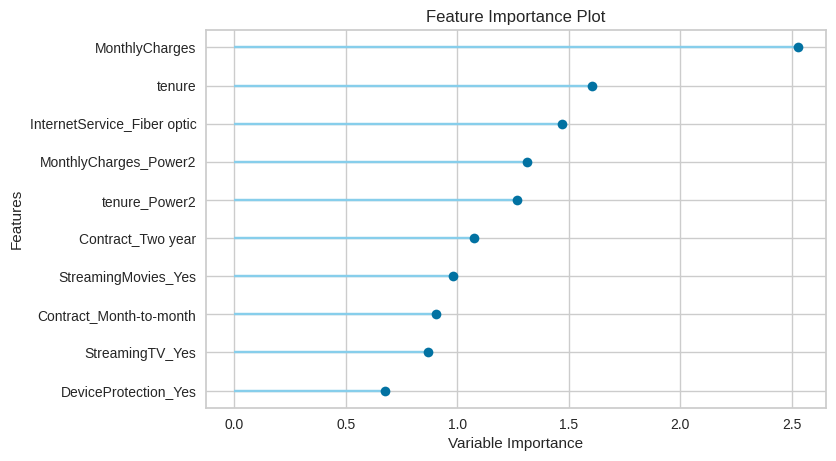

INFO  [logs] Visual Rendered Successfully
INFO  [logs] plot_model() succesfully completed......................................


In [24]:
#feature importance plot
plot_model(tuned_best_model_2, plot='feature')

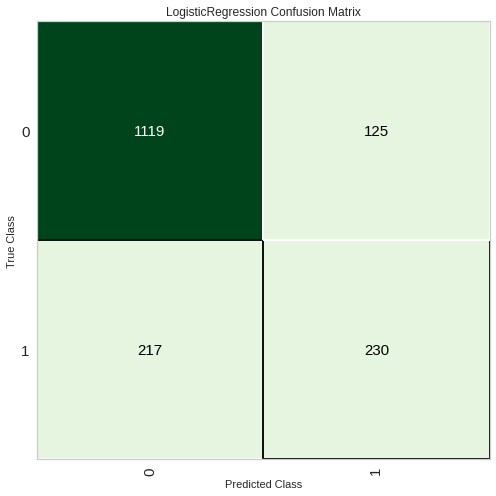

INFO  [logs] Visual Rendered Successfully
INFO  [logs] plot_model() succesfully completed......................................


In [25]:
#confusion matrix
plt.figure(figsize=(7,7))
plot_model(tuned_best_model_2, plot='confusion_matrix')

### Finalize the best model by training it on the whole data

In [26]:
#finalize the model
final_best_2 = finalize_model(tuned_best_model_2)

#save model to disk
save_model(final_best_2, 'churn_best_2')

INFO  [logs] Initializing finalize_model()
INFO  [logs] finalize_model(estimator=LogisticRegression(C=9.428772040268562, class_weight={}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), fit_kwargs=None, groups=None, model_only=True, display=None)
INFO  [logs] Finalizing LogisticRegression(C=9.428772040268562, class_weight={}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO  [logs] Initializing create_model()
INFO  [logs] create_model(estimator=LogisticRegression(C=9.428772040268562, class_weight={}, dual=False,
             

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['customerID'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Churn',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nu...
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  LogisticRegression(C=9.428772040268

### Register the model in MLflow

If one has already launched mlflow ui from experiment 1, then simply go to http://localhost:5000 to view the results. Otherwise, follow the same instructions as in experiment 1 to open the mlflow ui. Note that we can also **register models** in the mlflow ui.  We will register these two models as version 1 and version 2 of the **Best_Churn_Models**. Judging from the AUC, we will go with the tuned best model from experiment 1, i.e. we set the version 1 of the model to **production**.

## Save the test data for deployment purpose

In [27]:
#save test data for deployment purpose
data_test.drop('Churn', axis = 1).to_csv("test_data.csv", index = False)